#### Monte Carlo integration

Previously from Bayesian optimal tracking

* Prediction step

$$\begin{align*}
p(x_n|y_{0:n-1})=\int p(x_n| x_{n-1})p(x_{n-1}|y_{0:n-1})dx_{n-1}\\
\end{align*}$$

* Update step

$$p(x_n|y_{0:n})=\frac{p(y_n|x_n)}{p(y_n|y_{0:n-1})}p(x_n|y_{0:n-1})$$

we see that the integral in prediction step is really causing the headache, Monte Carlo (MC) integration is a possible way out of this

For the integral

$$\mu =\int g(x)dx$$

the idea of MC integration is first to factor $g(x)$ as $g(x)=f(x)p(x)$, where $p(x)$ is some PDF

$$p(x)\geq 0, \int p(x) dx =1$$

(and $p(x)>0$ wherever $g(x)>0$)

Then, by definition, this integral becomes expected value

$$\mu =\mathbb{E}[f(x)]$$

Suppose we can draw a large number of `independent` samples from $p(x)$, then, we can use samples to approximate the integral as

$$\begin{align*}
\mu&=\int g(x)dx \\
&=\int f(x) p(x) dx\\
&=\mathbb{E}[f(x)]\\
& \approx \hat{\mu}_N\\
&=\frac{1}{N}\sum_{i=1}^N f(x^i)
\end{align*}$$

where $x^i$ denotes the ith sample from $p(x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

#### Mean estimation example

Suppose we have a random process

$$y=\cos(v), v\sim N(0, \sigma_v^2)$$

and we wish to estimate

$$\mathbb{E}[y]=\int \cos(v) p(v) dv$$

In [27]:
# Numerical integration
n_bin = 10000
sigma_v = 1
v = np.linspace(-10, 10, n_bin)
w_bin = v[1] - v[0]

def g(v, sigma_v=sigma_v):
    return np.cos(v) * norm.pdf(v, 0, sigma_v)

e_y_num = np.sum(g(v) * w_bin)
print(f'Numerical integration: {e_y_num}')

Numerical integration: 0.6065306597124


In [43]:
# MC integration
np.random.seed(42)
n_sample = np.arange(1, 5000, 1)
mc_results = np.zeros_like(n_sample, dtype=float)

for idx, n in enumerate(n_sample):
    v_sample = np.random.normal(0, sigma_v, n)
    mc_results[idx] = np.mean(np.cos(v_sample))

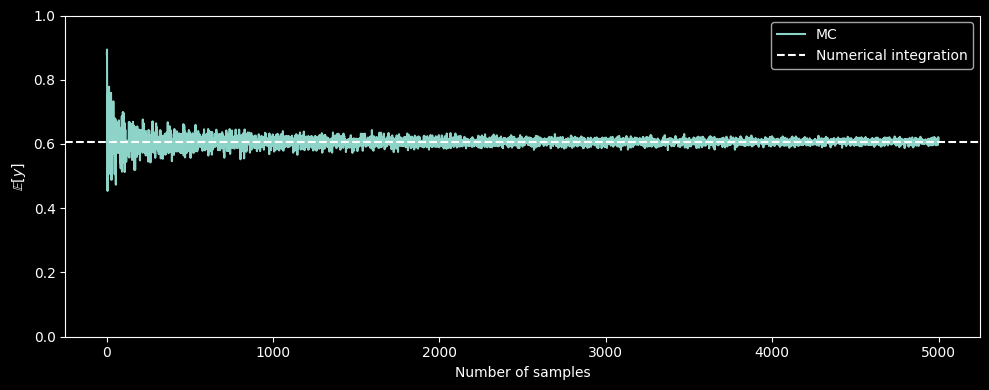

In [44]:
# Plot
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(n_sample, mc_results, '-', label='MC')
ax.set_xlabel('Number of samples')
ax.set_ylabel('$\mathbb{E}[y]$')
ax.set_ylim(0, 1)
ax.axhline(e_y_num, ls='--', label='Numerical integration')
ax.legend()

plt.tight_layout()
plt.show()